# Testing the RBC on MNIST data

The purpose of this notebook is to test the learning abilities of the RBM and RBC against standard training and testing datasets. In particular, we wish to examine the number of required training iterations, the convergence of scores, the reconstruction accuracy and the testing accuracy.

In [1]:
import sys

sys.path.append("../python")

In [2]:
import os
import numpy as np
import pandas as pd

In [3]:
import bernoulli_lib as blib

## Load the MNIST training data

The MNIST data files were downloaded from http://yann.lecun.com/exdb/mnist/.

In [4]:
def to_int(b):
    return int.from_bytes(b, byteorder='big', signed=False)

In [5]:
DATA_PATH = "../../../../data/MNIST"

### Load the training labels

In [6]:
with open(os.path.join(DATA_PATH, "train-labels-idx1-ubyte"), "rb") as fi:
    magic = to_int(fi.read(4))
    assert magic == 2049
    num_data = to_int(fi.read(4))
    Y_train = np.zeros(num_data, dtype=int)
    for i in range(num_data):
        Y_train[i] = to_int(fi.read(1))

In [7]:
num_classes = 1 + max(Y_train)
assert num_classes == 10  # number of digits

### Load the training vectors

In [8]:
with open(os.path.join(DATA_PATH, "train-images-idx3-ubyte"), "rb") as fi:
    magic = to_int(fi.read(4))
    assert magic == 2051
    num_data = to_int(fi.read(4))
    num_rows = to_int(fi.read(4))
    num_cols = to_int(fi.read(4))
    img_size = num_rows * num_cols
    X_train = np.zeros((num_data, img_size), dtype=int)
    for i in range(num_data):
        # Read byte-quantised pixels
        img = np.zeros(img_size, dtype=int)
        for j in range(img_size):
            img[j] = to_int(fi.read(1))
        # Convert to binary data
        X_train[i, :] = blib.binary_decision(img / 255)

In [9]:
import matplotlib.pyplot as plt

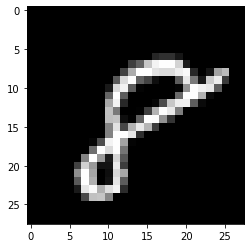

In [10]:
img = img.reshape((num_rows, num_cols))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

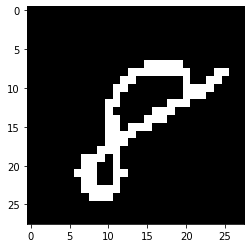

In [11]:
img = X_train[-1,:].reshape((num_rows, num_cols))
plt.imshow(img, cmap='gray', vmin=0, vmax=1)
plt.show()

In [12]:
Y_train[-1]

8

## Visualise the training data

We saw above one case of the raw training data, and its corresponding binarised image.
Here we shall visualise various averaged images of the training data.

### Inter-class mean

We first visualise the overall mean image, which corresponds to the proportion of cases for which each bit (or pixel) is *set* (i.e. takes the value 1).

In [13]:
import seaborn as sns

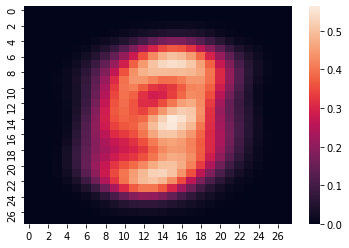

In [14]:
img = np.mean(X_train, axis=0).reshape((num_rows, num_cols))
ax = sns.heatmap(img)
plt.show()

### Intra-class means

We now visualise the mean image for each class of digits.

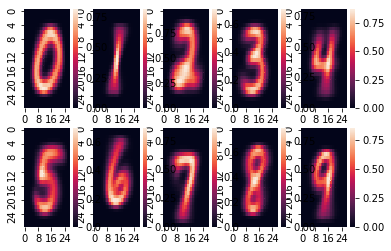

In [15]:
fig, ax = plt.subplots(2, 5)
for k in range(10):
    i = k // 5
    j = k % 5
    ind = Y_train == k
    img = np.mean(X_train[ind, :], axis=0).reshape((num_rows, num_cols))
    sns.heatmap(img, ax=ax[i, j])
plt.show()

## Unsupervised learning

We begin our experiments by ignoring the known class labels of the input images, and using unsupervised learning.

### Test learning speed

We first note that the RBM and RBC implementations have not particularly been optimised for speed. Hence, we suspect that learning might be a bit slow in comparison to well establish architectures.

We begin by estimating the speed of learning for varying numbers of training data cases.

In [16]:
from bernoulli_rbm import StandardBernoulliRBM

In [17]:
# Choose a reasonable but arbitrary number of hidden units
num_hidden = 32
# Choose a reasonable but arbitrary number of learning iterations
num_iterations = 50

In [18]:
import time

In [19]:
n_values = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]
t_values = [0] * len(n_values)
for i, num_cases in enumerate(n_values):
    start = time.time()
    rbm = StandardBernoulliRBM(num_hidden, img_size, n_iter=num_iterations)
    rbm.fit(X_train[0:num_cases, :])
    end = time.time()
    t_values[i] = end - start

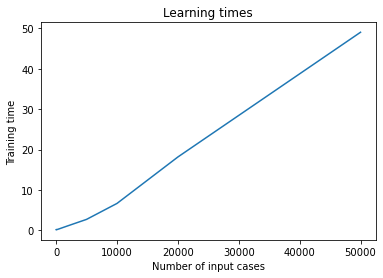

In [20]:
plt.plot(n_values, t_values)
plt.title("Learning times")
plt.xlabel("Number of input cases")
plt.ylabel("Training time")
plt.show()

Okay, the time vs input-size curve appears to be reasonably linear.

Let us now look at time per iteration.

In [21]:
# Choose a reasonable but arbitrary number of training cases
num_cases = 10000

In [22]:
n_values = [1, 2, 5, 10, 20, 50, 100, 200, 500]
t_values = [0] * len(n_values)
for i, num_iterations in enumerate(n_values):
    start = time.time()
    rbm = StandardBernoulliRBM(num_hidden, img_size, n_iter=num_iterations)
    rbm.fit(X_train[0:num_cases, :])
    end = time.time()
    t_values[i] = end - start

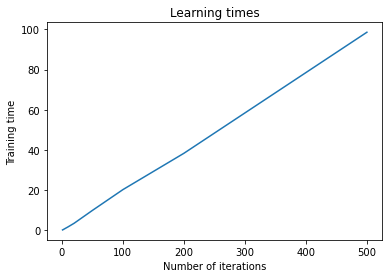

In [23]:
plt.plot(n_values, t_values)
plt.title("Learning times")
plt.xlabel("Number of iterations")
plt.ylabel("Training time")
plt.show()

The time vs iterations curve also appears to be linear.

From the two experiments, we see that training 50,000 cases over 50 iterations took about 50 seconds, so we expect the 60,000 actual training cases to take about 1 minute to train for 50 iterations.

Next, we look at the effect of varying the number of hidden units on the computational time.

In [24]:
# Choose a reasonable but arbitrary number of learning iterations
num_iterations = 50

In [25]:
n_values = [1, 2, 5, 10, 20, 50, 100, 200, 500]
t_values = [0] * len(n_values)
for i, num_hidden in enumerate(n_values):
    start = time.time()
    rbm = StandardBernoulliRBM(num_hidden, img_size, n_iter=num_iterations)
    rbm.fit(X_train[0:num_cases, :])
    end = time.time()
    t_values[i] = end - start

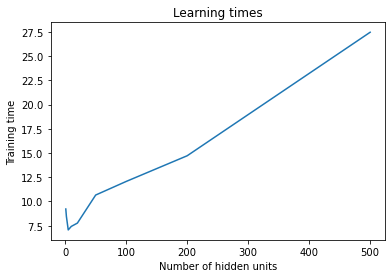

In [26]:
plt.plot(n_values, t_values)
plt.title("Learning times")
plt.xlabel("Number of hidden units")
plt.ylabel("Training time")
plt.show()

We see that the time vs hidden units curve is approximately linear.

### Sanity checking the log-likelihood score

Before we begin to examine the training performance of the RBM,  
let us take a look at some computable measures we can use for sanity checking. Firstly, we recall that the RBM models the assumption that the bits in the input vector are independent. Thus, let us simplistically suppose that for each bit there is a constant probability $\bar{p}$ of the bit having value 1 (i.e. the bit is *set*). Next, for a given vector ${\bf x}$ of F bits, suppose we have $n$ bits set and $F-n$ bits unset. Then the log-likelihood of ${\bf x}$ is
\begin{eqnarray}
\ln p({\bf x}) & = & n\ln\bar{p}+(F-n)\ln(1-\bar{p})
= F\left\{\bar{n}\ln\bar{p}+(1-\bar{n})\ln(1-\bar{p})\right\}
\,,
\end{eqnarray}
where $\bar{n}=n/F$ is the proportion of bits that are set.
Taking the average over the $N$ training cases, 
we obtain $\mathbb{E}[\bar{n}]=\bar{p}$, such that the mean log-likelihood of input data ${\bf X}$ is
\begin{eqnarray}
\frac{1}{N}\ln p({\bf X}) & = & 
F\left\{\bar{p}\ln\bar{p}+(1-\bar{p})\ln(1-\bar{p})\right\}
\,.
\end{eqnarray}

In [27]:
p_bar = np.mean(X_train)
q_bar = 1 - p_bar
print("p(x_i=1) = %f, p(x_i=0) = %f " % (p_bar, q_bar))
score = X_train.shape[1] * (p_bar * np.log(p_bar) + q_bar * np.log(q_bar))
print("E[log p(x)] =", score)

p(x_i=1) = 0.132258, p(x_i=0) = 0.867742 
E[log p(x)] = -306.27526689195867


The next variant is to suppose that the $i$-th bit in ${\bf x}$ has independent probability $\bar{p}_i$ of being set, such that
\begin{eqnarray}
\frac{1}{N}\ln p({\bf X}) & = & 
\sum_{i=1}^{F}\left\{\bar{p}_i\ln\bar{p}_i+(1-\bar{p}_i)\ln(1-\bar{p}_i)\right\}
\,.
\end{eqnarray}

In [28]:
p_bar = np.mean(X_train, axis=0)
zero_ind = p_bar == 0
print("%s bits are always unset" % np.sum(zero_ind))
p_bar[zero_ind] = 1e-30
q_bar = 1 - p_bar
score = np.sum(p_bar * np.log(p_bar) + q_bar * np.log(q_bar))
print("E[log p(x)] =", score)

108 bits are always unset
E[log p(x)] = -206.04296291482848


We see that the model with unequal bit-wise probabilities (with score -206) fits the training data better than the model with a constant bit probability (with score -306).
The score of -206 will thus form our baseline for comparing the training scores of various RBM models.

Lastly, we note that for the simplest model, the log-likelihood score as a function of $\bar{p}$ is minimised when $\bar{p}=0.5$, which indicates maximum uncertainty as to whether any given bit should be set or unset.

In [29]:
score = X_train.shape[1] * np.log(0.5)
print("min E[log p(x)] =", score)

min E[log p(x)] = -543.4273895589971


Thus, we might expect a completely untrained model (with near-zero weights) to have a baseline score (i.e. the 'x_score' measure) of around -543.

### Test reconstruction of inputs

The first challenge is to train the standard Bernoulli RBM on the full data-set. We wish to see how varying the number of hidden units affects the ability to approximately reconstruct the input.

#### 1 hidden bit

We begin by looking at the simplest RBM with only 1 hidden/output bit.
We allow for the effect of random initialisation by repeating the experiment.

In [30]:
num_hidden = 1
print("num_hidden =", num_hidden)

num_hidden = 1


In [31]:
for i in range(2):
    rbm = StandardBernoulliRBM(
        num_hidden, img_size, 
        n_iter=500, n_report=100,
    )
    rbm.fit(X_train)

Iteration 0: xy_score=-544.118419, y_score=-0.693143, x_score=-543.425276, rmse=13.999962, mae=396.620183
Iteration 100: xy_score=-199.123573, y_score=-0.002769, x_score=-199.120804, rmse=8.074413, mae=100.208100
Iteration 200: xy_score=-198.818171, y_score=-0.002335, x_score=-198.815836, rmse=8.076011, mae=100.252750
Iteration 300: xy_score=-198.722484, y_score=-0.002224, x_score=-198.720260, rmse=8.076508, mae=100.263883
Iteration 400: xy_score=-198.682049, y_score=-0.002169, x_score=-198.679879, rmse=8.076900, mae=100.273083
Iteration 500: xy_score=-198.659822, y_score=-0.002131, x_score=-198.657691, rmse=8.077188, mae=100.280383
Iteration 0: xy_score=-544.117720, y_score=-0.693143, x_score=-543.424576, rmse=13.999950, mae=391.831950
Iteration 100: xy_score=-199.123589, y_score=-0.002769, x_score=-199.120820, rmse=8.074413, mae=100.208150
Iteration 200: xy_score=-198.818182, y_score=-0.002335, x_score=-198.815847, rmse=8.076011, mae=100.252767
Iteration 300: xy_score=-198.722487, y_

We recall that an RBM with 1 output bit (let us call this output $h$) corresponds to the model
\begin{eqnarray}
p(h=1\mid{\bf x}) & = & \sigma(b+{\bf w}^T{\bf x})\,,
\\
p(x_i=1\mid h) & = & \sigma(a_i+w_i h)\,,
\end{eqnarray}
where $\sigma(\cdot)$ is the logistic sigmoid function. Hence, the simplest model from above (with score -306) corresponds to ${\bf w}=\mathbf{0}$ and ${\bf a}=k\mathbf{1}$, for some scalar constant $k$. Likewise, our baseline model (with score -206) corresponds
to ${\bf w}=\mathbf{0}$ and ${\bf a}\ne k\mathbf{1}$.

However, we can do better than the baseline. From the equations above, we see that
the probability of the output bit being set is a monotonically increasing function of a weighted
sum of the number of bits set in input ${\bf x}$.
If, for example, ${\bf w}>\mathbf{0}$, then the more input bits that are set, the higher
the value of $\bar{h}=p(h=1\mid{\bf x})$, and the higher the reconstruction
probability $p(x_i=1\mid\bar{h})$.

We observe from the training runs above that the initial scores start at the minimum
of -543, and then appear to be converging to about -198, which exceeds the baseline of -206. However, we also note that the root-mean-square and mean absolute errors appear to be increasing (which might indicate over-training).

#### 10 hidden bits

We know that the MNIST data-set has 10 distinct classes, corresponding to the digits 
0-9. Hence, it might be supposed that each digit has its own canonical image that represents the mean of intra-class cases.

Therefore, let us examine the model with 10 hidden output bits.

In [32]:
num_hidden = 10
print("num_hidden =", num_hidden)

num_hidden = 10


In [33]:
rbm = StandardBernoulliRBM(
    num_hidden, img_size, 
    n_iter=500, n_report=100,
)
rbm.fit(X_train)

Iteration 0: xy_score=-550.358308, y_score=-6.931471, x_score=-543.426836, rmse=13.999990, mae=392.276417
Iteration 100: xy_score=-151.072729, y_score=-0.231921, x_score=-150.840808, rmse=7.000096, mae=73.128917
Iteration 200: xy_score=-150.822325, y_score=-0.189460, x_score=-150.632865, rmse=7.016648, mae=74.043067
Iteration 300: xy_score=-150.482233, y_score=-0.178729, x_score=-150.303504, rmse=7.014089, mae=73.979883
Iteration 400: xy_score=-150.254241, y_score=-0.173552, x_score=-150.080689, rmse=7.010926, mae=73.747150
Iteration 500: xy_score=-150.087526, y_score=-0.172800, x_score=-149.914725, rmse=7.009100, mae=73.596600


Although the scores do not appear to have converged, we see that the model (with score -149) fits the training data better than the baseline (with score -206).

Let us examine the parameter values.

In [34]:
import seaborn as sns

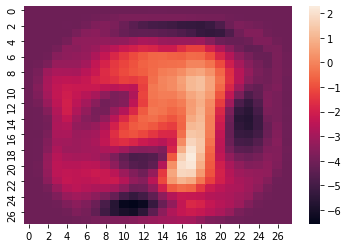

In [35]:
a, W, b = rbm.get_parameters()
img = a.reshape((num_rows, num_cols))
ax = sns.heatmap(img)
plt.show()

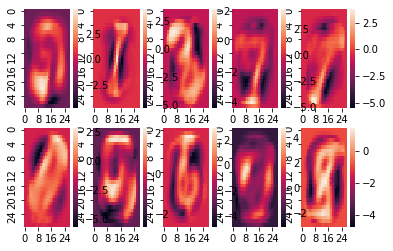

In [36]:
fig, ax = plt.subplots(2, 5)
for k in range(10):
    i = k // 5
    j = k % 5
    img = W[:, k].reshape((num_rows, num_cols))
    sns.heatmap(img, ax=ax[i, j])
plt.show()

We observe that unsupervised learning doesn't automatically separate the inputs into the correct digit classes,
although possibly a few digits are recognisable.
Later, we shall check how supervised learning does on this task.

#### Variable hidden outputs

We now compare the behaviours of training the RBM for varying numbers of output bits. 

In [37]:
n_values = [1, 2, 5, 10, 20, 50, 100, 200, 500]
t_values = [0] * len(n_values)
xy_values = [0] * len(n_values)
x_values = [0] * len(n_values)
r_values = [0] * len(n_values)
for i, num_hidden in enumerate(n_values):
    print("num_hidden =", num_hidden)
    start = time.time()
    rbm = StandardBernoulliRBM(
        num_hidden, img_size, 
        n_iter=500, n_report=100,
    )
    rbm.fit(X_train)
    end = time.time()
    t_values[i] = end - start
    scores = rbm.score(X_train)
    xy_values[i] = scores['xy_score']
    x_values[i] = scores['x_score']
    r_values[i] = scores['rmse']

num_hidden = 1
Iteration 0: xy_score=-544.124758, y_score=-0.693143, x_score=-543.431615, rmse=14.000075, mae=403.775350
Iteration 100: xy_score=-199.123523, y_score=-0.002770, x_score=-199.120753, rmse=8.074412, mae=100.208083
Iteration 200: xy_score=-198.818237, y_score=-0.002336, x_score=-198.815902, rmse=8.076010, mae=100.252717
Iteration 300: xy_score=-198.722573, y_score=-0.002224, x_score=-198.720349, rmse=8.076508, mae=100.263883
Iteration 400: xy_score=-198.682126, y_score=-0.002169, x_score=-198.679956, rmse=8.076900, mae=100.273100
Iteration 500: xy_score=-198.659930, y_score=-0.002131, x_score=-198.657799, rmse=8.077189, mae=100.280367
num_hidden = 2
Iteration 0: xy_score=-544.811340, y_score=-1.386292, x_score=-543.425048, rmse=13.999958, mae=390.236467
Iteration 100: xy_score=-190.799518, y_score=-0.017991, x_score=-190.781527, rmse=7.915993, mae=96.832150
Iteration 200: xy_score=-189.889109, y_score=-0.018121, x_score=-189.870988, rmse=7.911013, mae=96.762583
Iteration 3

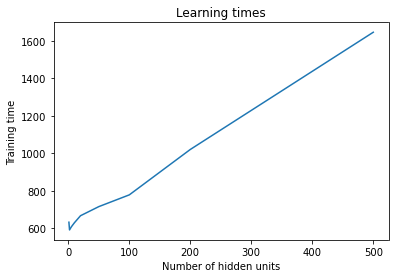

In [38]:
plt.plot(n_values, t_values)
plt.title("Learning times")
plt.xlabel("Number of hidden units")
plt.ylabel("Training time")
plt.show()

We see that training time is roughly linear in the number of hidden units.

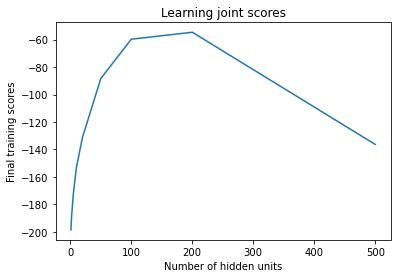

In [39]:
plt.plot(n_values, xy_values)
plt.title("Learning joint scores")
plt.xlabel("Number of hidden units")
plt.ylabel("Final training scores")
plt.show()

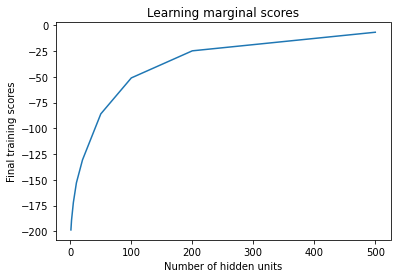

In [40]:
plt.plot(n_values, x_values)
plt.title("Learning marginal scores")
plt.xlabel("Number of hidden units")
plt.ylabel("Final training scores")
plt.show()

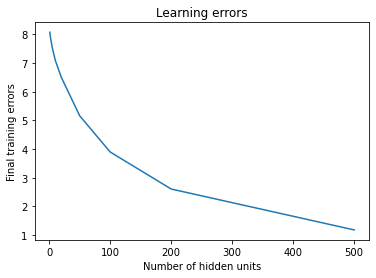

In [41]:
plt.plot(n_values, r_values)
plt.title("Learning errors")
plt.xlabel("Number of hidden units")
plt.ylabel("Final training errors")
plt.show()

We observe that having more hidden units allows for better reconstruction of the input.
In principle, if we have the same number of outputs as inputs,
then we should be able to perfectly reconstruct each input (subject to random initialisation and being stuck in a local optimum).

We also note that training has seemingly converged for small numbers of hidden units, but not for larger values. Since there are more parameters to be estimated in the latter case, then more iterations are required.

In [42]:
rbm.fit(X_train)

Iteration 0: xy_score=-136.369673, y_score=-129.556284, x_score=-6.813389, rmse=1.181599, mae=1.407167
Iteration 100: xy_score=-132.282803, y_score=-126.911890, x_score=-5.370912, rmse=1.014423, mae=0.977433
Iteration 200: xy_score=-129.244740, y_score=-124.838308, x_score=-4.406432, rmse=0.891095, mae=0.708833
Iteration 300: xy_score=-126.820097, y_score=-123.094418, x_score=-3.725680, rmse=0.796555, mae=0.531000
Iteration 400: xy_score=-124.794519, y_score=-121.570778, x_score=-3.223741, rmse=0.721580, mae=0.408383
Iteration 500: xy_score=-123.048224, y_score=-120.208006, x_score=-2.840218, rmse=0.660426, mae=0.314950


## Supervised learning

We now turn to the problem of learning to classify the known digit of each input image.

### Logistic classification

Perhaps the simplest classifier to try first is the logistic linear classifier.
Let us see how this learns our training data.

In [43]:
from bernoulli_rbm import LogisticBernoulliRBC

In [44]:
rbc = LogisticBernoulliRBC(
    num_classes, img_size,
    n_iter=100, n_report=10,
)
rbc.fit(X_train, Y_train)

Iteration 0: xy_score=-545.730041, y_score=-2.302638, x_score=-543.427403, rmse=14.000000, mae=383.031200
Iteration 10: xy_score=-186.578947, y_score=-2.035185, x_score=-184.543762, rmse=7.557754, mae=84.822217
Iteration 20: xy_score=-178.704443, y_score=-2.719946, x_score=-175.984496, rmse=7.451825, mae=83.096000
Iteration 30: xy_score=-176.115899, y_score=-2.984853, x_score=-173.131046, rmse=7.426083, mae=82.732400
Iteration 40: xy_score=-174.854525, y_score=-3.099497, x_score=-171.755028, rmse=7.416925, mae=82.682717
Iteration 50: xy_score=-174.106259, y_score=-3.153207, x_score=-170.953052, rmse=7.412777, mae=82.653500
Iteration 60: xy_score=-173.606112, y_score=-3.179644, x_score=-170.426469, rmse=7.410509, mae=82.658450
Iteration 70: xy_score=-173.244416, y_score=-3.192461, x_score=-170.051955, rmse=7.409017, mae=82.632900
Iteration 80: xy_score=-172.967348, y_score=-3.198113, x_score=-169.769235, rmse=7.407919, mae=82.638350
Iteration 90: xy_score=-172.749272, y_score=-3.199854,

It looks like optimising the joint log-likelihood (the 'xy_score') is also optimising the marginal log-likelihood (the 'x_score'), but at the expense of the discriminative log-likelihood (the 'y_score').

Let us try a smaller gradient update step-size than the default of 0.5.

In [45]:
rbc = LogisticBernoulliRBC(
    num_classes, img_size,
    n_iter=100, n_report=10,
    step_size=0.1,
)
rbc.fit(X_train, Y_train)

Iteration 0: xy_score=-545.730100, y_score=-2.302598, x_score=-543.427502, rmse=14.000002, mae=407.329633
Iteration 10: xy_score=-233.925780, y_score=-0.722739, x_score=-233.203041, rmse=8.187692, mae=93.966900
Iteration 20: xy_score=-206.960656, y_score=-1.124808, x_score=-205.835848, rmse=7.841274, mae=89.877433
Iteration 30: xy_score=-196.385878, y_score=-1.486602, x_score=-194.899277, rmse=7.698189, mae=87.345900
Iteration 40: xy_score=-190.485243, y_score=-1.785429, x_score=-188.699814, rmse=7.613564, mae=86.013667
Iteration 50: xy_score=-186.700626, y_score=-2.028441, x_score=-184.672185, rmse=7.558620, mae=84.827850
Iteration 60: xy_score=-184.083312, y_score=-2.226311, x_score=-181.857001, rmse=7.521290, mae=84.241950
Iteration 70: xy_score=-182.180274, y_score=-2.387149, x_score=-179.793126, rmse=7.495112, mae=83.786683
Iteration 80: xy_score=-180.744256, y_score=-2.518217, x_score=-178.226039, rmse=7.476276, mae=83.625350
Iteration 90: xy_score=-179.628465, y_score=-2.625558,

Unfortunately, it looks like we are only slowing down the effect. It was hoped that both the marginal and discriminative scores would simultaneously be maximised. However, as long as the joint score is increasing, as expected, we have no control over the individual scores.

Let us therefore try again by directly optimising the discriminative log-likelihood.

In [46]:
rbc = LogisticBernoulliRBC(
    num_classes, img_size,
    is_discriminative=True,
    n_iter=500, n_report=100,
)
rbc.fit(X_train, Y_train)

Iteration 0: xy_score=-545.729962, y_score=-2.302512, x_score=-543.427450, rmse=14.000001, mae=387.497917
Iteration 100: xy_score=-199.386807, y_score=-0.304671, x_score=-199.082136, rmse=8.034242, mae=96.541883
Iteration 200: xy_score=-198.391104, y_score=-0.309910, x_score=-198.081194, rmse=8.018070, mae=96.285550
Iteration 300: xy_score=-197.832577, y_score=-0.322913, x_score=-197.509664, rmse=8.008181, mae=96.340267
Iteration 400: xy_score=-197.449743, y_score=-0.337797, x_score=-197.111946, rmse=8.001391, mae=96.362317
Iteration 500: xy_score=-197.167644, y_score=-0.353279, x_score=-196.814365, rmse=7.996493, mae=96.158067


It seems that optimising the discriminative likelihood did indeed improve the predictive ability, but again the discriminative scores worsen with further iterations. So, let us again try slowing the gradient update.

In [47]:
rbc = LogisticBernoulliRBC(
    num_classes, img_size,
    is_discriminative=True,
    n_iter=500, n_report=100,
    step_size=0.1,
)
rbc.fit(X_train, Y_train)

Iteration 0: xy_score=-545.730165, y_score=-2.302555, x_score=-543.427610, rmse=14.000004, mae=395.725850
Iteration 100: xy_score=-203.315409, y_score=-0.352477, x_score=-202.962932, rmse=8.070654, mae=97.087250
Iteration 200: xy_score=-201.087860, y_score=-0.322987, x_score=-200.764874, rmse=8.053763, mae=96.854700
Iteration 300: xy_score=-200.238447, y_score=-0.311808, x_score=-199.926639, rmse=8.045154, mae=96.723450
Iteration 400: xy_score=-199.741788, y_score=-0.306773, x_score=-199.435015, rmse=8.039089, mae=96.585083
Iteration 500: xy_score=-199.392584, y_score=-0.304681, x_score=-199.087902, rmse=8.034254, mae=96.497500


We see that we have prevented overshooting, and now the scores look like they are converging. However, is this true convergence, or simply because the step-size is small?

In [48]:
grads = rbc._compute_score_gradients(X_train, Y_train)

In [49]:
for grad in grads:
    print("max. abs. gradient =", np.max(np.abs(grad)))

max. abs. gradient = 0.002015839582209767
max. abs. gradient = 0.0015599085947992232
max. abs. gradient = 4.360267283443875


We see that the gradient for parameter 'b' is still significant. Perhaps we need different step-sizes for each parameter? Alternatively, we need some sort of adaptive
step-sizing related to the magnitude of each update.

Let us now see what parameter values have been estimated.

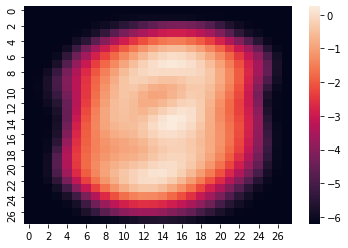

In [50]:
a, W, b = rbc.get_parameters()
img = a.reshape((num_rows, num_cols))
ax = sns.heatmap(img)
plt.show()

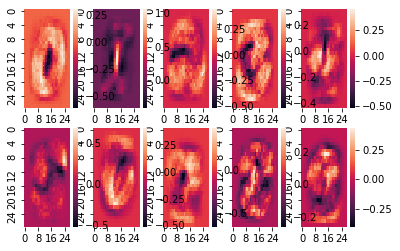

In [51]:
fig, ax = plt.subplots(2, 5)
for k in range(10):
    i = k // 5
    j = k % 5
    img = W[:, k].reshape((num_rows, num_cols))
    sns.heatmap(img, ax=ax[i, j])
plt.show()

The weights for classes 4 and 7 do not visually resemble their corresponding digits, although the other
weights are reasonable approximations.

Let us see how one input example from each class is classified.

In [52]:
for k in range(10):
    ind = Y_train == k
    x = X_train[ind, :][0:1, :]
    y = rbc.predict(x)
    print("class", k, ", probs =", y)

class 0 , probs = [[9.99548767e-01 1.80751437e-11 1.57391331e-05 6.86680563e-06
  1.87996103e-08 3.91376867e-04 9.59352033e-06 2.90247346e-06
  2.15207680e-05 3.21413031e-06]]
class 1 , probs = [[5.08765346e-06 9.78211909e-01 8.60906493e-03 7.56657160e-04
  1.00665151e-04 3.66118722e-04 1.19701287e-04 9.91816384e-05
  1.16712462e-02 6.03678946e-05]]
class 2 , probs = [[8.41649457e-04 9.37682968e-08 9.73888206e-01 1.31313267e-03
  3.33742449e-05 2.27279703e-03 2.44005777e-05 2.50336193e-04
  1.04647343e-02 1.09112762e-02]]
class 3 , probs = [[1.38422491e-04 2.28788478e-08 7.18696991e-04 9.95414549e-01
  3.68501160e-07 2.23275405e-04 1.35494592e-08 2.51754124e-06
  3.20879487e-03 2.93338998e-04]]
class 4 , probs = [[3.13046533e-04 4.88163101e-06 1.65868770e-02 4.62398021e-02
  9.21490834e-01 8.22878250e-04 2.25664286e-03 1.27287533e-03
  2.96659221e-03 8.04556990e-03]]
class 5 , probs = [[2.96489253e-03 1.11256730e-06 2.89164373e-03 2.08154554e-01
  3.63643281e-06 7.80617150e-01 3.129274

Instead, let us see how each of these examples projects onto the weight vectors.

In [53]:
for k in range(10):
    ind = Y_train == k
    x = X_train[ind, :][0, :]
    z = np.matmul(x, W)
    y = np.argmax(z)
    print("class", k, ", idx =", y, ", proj =", z)

class 0 , idx = 0 , proj = [11.75084231 -7.78742031  0.67658903  1.09903517 -6.86447245 -0.27542311
 -0.07614332  0.37492037  1.77410781 -0.67291221]
class 1 , idx = 1 , proj = [-5.17054582 12.19388851  2.24786424  1.06810078 -3.01189926 -5.07528203
 -2.28537748 -0.82683565  3.33682727 -2.47315722]
class 2 , idx = 2 , proj = [ 2.41446020e-04 -3.90428118e+00  7.03858542e+00  1.68160181e+00
 -4.05367406e+00 -3.18723279e+00 -3.81352966e+00  1.61256618e-01
  3.28995039e+00  2.78617779e+00]
class 3 , idx = 3 , proj = [ 0.94725288 -2.56283068  2.57903797 11.06440997 -5.80770547 -2.75552879
 -8.5574806  -1.68620093  4.85989936  1.92201917]
class 4 , idx = 4 , proj = [-2.61341927 -1.57652229  1.34125179  3.61837816  4.5476406  -5.82784001
 -0.91115189  0.16283653  0.40470435  0.85685368]
class 5 , idx = 3 , proj = [ 0.55433757 -2.13581883  0.51397767  6.04233069 -6.97559169  1.94670446
 -1.96730149  1.71097485  0.8730934  -0.55985723]
class 6 , idx = 6 , proj = [-3.36661278 -1.69069494  2.7567

Hmm, we see that some examples (0-3, 6-7) project well (i.e. the maximum component of projection occurs at the class index), but other examples (4-5, 8-9) do not. However, the logistic classifier also has the bias term ${\bf b}$ to help distinguish between classes. Let us also make use of this parameter.

In [54]:
for k in range(10):
    ind = Y_train == k
    x = X_train[ind, :][0, :]
    z = np.matmul(x, W) + b
    y = np.argmax(z)
    print("class", k, ", idx =", y, ", proj =", z)

class 0 , idx = 0 , proj = [2189.06804684 2164.33201478 2178.00913778 2177.17968664 2171.27906847
 2181.22265856 2177.51407552 2176.3185509  2178.32200604 2176.42054442]
class 1 , idx = 1 , proj = [2172.14665871 2184.31332359 2179.58041298 2177.14875225 2175.13164166
 2176.42279965 2175.30484135 2175.11679489 2179.8847255  2174.62029941]
class 2 , idx = 2 , proj = [2177.31744598 2168.2151539  2184.37113417 2177.76225328 2174.08986686
 2178.31084889 2173.77668918 2176.10488716 2179.83784862 2179.87963442]
class 3 , idx = 3 , proj = [2178.26445741 2169.5566044  2179.91158671 2187.14506144 2172.33583546
 2178.74255288 2169.03273823 2174.2574296  2181.40779759 2179.0154758 ]
class 4 , idx = 4 , proj = [2174.70378526 2170.5429128  2178.67380053 2179.69902963 2182.69118152
 2175.67024167 2176.67906694 2176.10646707 2176.95260258 2177.95031031]
class 5 , idx = 5 , proj = [2177.8715421  2169.98361626 2177.84652642 2182.12298216 2171.16794924
 2183.44478614 2175.62291735 2177.65460539 2177.4209

Note that if we write the centred projection of ${\bf x}$ as $({\bf x}-\bar{\bf x})^T W$, where $\bar{\bf x}$
represents the overall mean of ${\bf x}$, then we see that 
(notionally, or in fact) ${\bf b}=-\bar{\bf x}^T W$.

### Utilising a hidden layer

Above, we trained a logistic RBM classifier. This is linear in its arguments (and parameters), and possesses nonlinearity only through the soft-max function.
We now turn to the case of extending the nonlinearity by including a hidden layer between the input and output.

In [55]:
from bernoulli_rbm import StandardBernoulliRBC

We need to specify how many hidden units to use. Essentially, each binary input image is compressed to a hidden binary representation, and then classified. We know from our  experiments above that the bigger the hidden layer, the better we can reconstruct the input. However, the idea is to see what lower-dimensional, latent patterns can be extracted from the training data, in order to help us with the classification task.

For simplicity, let us start with 10 hidden units, to get a feel for training performance.

In [56]:
n_hidden = 10

In [57]:
rbc = StandardBernoulliRBC(
    n_hidden, num_classes, img_size,
    n_iter=500, n_report=100,
    step_size=0.1,
)
rbc.fit(X_train, Y_train)

Iteration 0: xy_score=-545.729394, y_score=-2.302596, x_score=-543.426798, rmse=13.999989, mae=393.945300
Iteration 100: xy_score=-168.310057, y_score=-1.392857, x_score=-166.917200, rmse=7.322074, mae=80.050700
Iteration 200: xy_score=-163.847876, y_score=-1.265713, x_score=-162.582162, rmse=7.275869, mae=80.481583
Iteration 300: xy_score=-161.464507, y_score=-1.223787, x_score=-160.240719, rmse=7.240190, mae=79.874650
Iteration 400: xy_score=-158.596381, y_score=-1.154831, x_score=-157.441550, rmse=7.172207, mae=78.538033
Iteration 500: xy_score=-154.986215, y_score=-1.038892, x_score=-153.947323, rmse=7.075754, mae=75.236500


We observe that the discriminative log-likelihood (the 'y_score') is not nearly as good as for the logistic RBC above. However, note that here we are optimising the joint log-likelihood (the 'xy_score'), with the result that the (reconstructive) marginal log-likelihood (the 'x_score') shows marked improvement.

Presumably using only 10 hidden units produces too drastic a dimensionality reduction, which limits the model's ability to recover the input.

Let us instead reduce the input dimensionality by half.

In [58]:
n_hidden = img_size // 2
print("n_input=%d, n_hidden=%d" % (img_size, n_hidden))

n_input=784, n_hidden=392


In [59]:
rbc = StandardBernoulliRBC(
    n_hidden, num_classes, img_size,
    n_iter=500, n_report=100,
    step_size=0.1,
)
rbc.fit(X_train, Y_train)

Iteration 0: xy_score=-545.730031, y_score=-2.302592, x_score=-543.427439, rmse=14.000001, mae=390.575350
Iteration 100: xy_score=-59.888925, y_score=-0.370043, x_score=-59.518881, rmse=4.121305, mae=22.119250
Iteration 200: xy_score=-41.255359, y_score=-0.311551, x_score=-40.943808, rmse=3.348379, mae=14.039033
Iteration 300: xy_score=-32.786257, y_score=-0.284532, x_score=-32.501725, rmse=2.946115, mae=10.610917
Iteration 400: xy_score=-27.771126, y_score=-0.274312, x_score=-27.496814, rmse=2.685486, mae=8.684383
Iteration 500: xy_score=-24.370087, y_score=-0.268830, x_score=-24.101257, rmse=2.495528, mae=7.411167


Observe that we have now improved on both the discriminative log-likelihood **and** the marginal log-likelihood, even though (by default) the model is optimising only the joint log-likelihood. It would therefore seem that there is indeed some latency in our input images that can be exploited.

Let us now explore the dimensionality reduction a little further.

In [60]:
for n_hidden in [100, 200, 300, 400, 500, 600, img_size]:
    print("n_hidden=%d" % n_hidden)
    rbc = StandardBernoulliRBC(
        n_hidden, num_classes, img_size,
        n_iter=500, n_report=100,
        step_size=0.1,
    )
    rbc.fit(X_train, Y_train)

n_hidden=100
Iteration 0: xy_score=-545.730403, y_score=-2.302564, x_score=-543.427838, rmse=14.000008, mae=394.214317
Iteration 100: xy_score=-88.438530, y_score=-0.431960, x_score=-88.006570, rmse=5.128260, mae=35.716883
Iteration 200: xy_score=-74.732115, y_score=-0.374398, x_score=-74.357718, rmse=4.696091, mae=29.845667
Iteration 300: xy_score=-68.791446, y_score=-0.356725, x_score=-68.434721, rmse=4.500435, mae=27.388033
Iteration 400: xy_score=-65.193953, y_score=-0.346739, x_score=-64.847213, rmse=4.378387, mae=25.918383
Iteration 500: xy_score=-62.675695, y_score=-0.338741, x_score=-62.336954, rmse=4.291932, mae=24.907317
n_hidden=200
Iteration 0: xy_score=-545.730044, y_score=-2.302591, x_score=-543.427453, rmse=14.000001, mae=388.402550
Iteration 100: xy_score=-72.123100, y_score=-0.373506, x_score=-71.749595, rmse=4.575946, mae=27.832467
Iteration 200: xy_score=-55.240888, y_score=-0.334580, x_score=-54.906308, rmse=3.953656, mae=20.391333
Iteration 300: xy_score=-47.264883

We observe that possibly there is a useful upper limit on the number of hidden units,
although we would need to let all training runs proceed to convergence to be sure.

Finally, let us see how switching on discriminative training works.

In [61]:
n_hidden = img_size // 2

In [62]:
rbc = StandardBernoulliRBC(
    n_hidden, num_classes, img_size,
    is_discriminative=True,
    n_iter=500, n_report=100,
    step_size=0.1,
)
rbc.fit(X_train, Y_train)

Iteration 0: xy_score=-545.730179, y_score=-2.302577, x_score=-543.427603, rmse=14.000004, mae=407.987450
Iteration 100: xy_score=-187.182928, y_score=-0.586663, x_score=-186.596265, rmse=7.657744, mae=85.192450
Iteration 200: xy_score=-185.675232, y_score=-0.348314, x_score=-185.326918, rmse=7.677384, mae=86.628067
Iteration 300: xy_score=-188.572552, y_score=-0.301944, x_score=-188.270608, rmse=7.771733, mae=89.830683
Iteration 400: xy_score=-191.256615, y_score=-0.279724, x_score=-190.976892, rmse=7.847795, mae=91.865717
Iteration 500: xy_score=-189.824814, y_score=-0.298279, x_score=-189.526535, rmse=7.816803, mae=90.888033


Here we see that discriminative training is not fitting the input very well (as expected), and is also not fitting the output as well as we saw above for joint log-likelihood optimisation. Overall, it seems that we can both overfit and underfit the input at the expense of the output, but that conversely it is possible to fit both input and output well. In general, using the joint log-likelihood causes the model to reconstruct both the inputs and outputs, and both the observed and reconstructed values inform the gradient to provide a better fit.